**Big Data Coursework**

```
By Kushal Sarkar and Dennis Tamang (L6CG2)
```

Each and every section of this analysis is explained in details in report [here](https://drive.google.com/file/d/19VXrwEJxVmVJ8dRQBJSEMlVpiKR6zt7B/view?usp=share_link).

# **PySpark and HDFS**
To store the `Kickstarter.csv` dataset in **HDFS** using **PySpark**, you would typically use the hadoop fs command, which is a command-line tool for interacting with HDFS. This command can be used to copy files from the local file system to HDFS, as well as to retrieve and manipulate data stored in HDFS. Once the data is stored in HDFS, I can use PySpark to read and process the data using Spark's distributed computing capabilities, which can be used to perform a wide range of data processing tasks, such as filtering, grouping, aggregation, and machine learning.

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=d9c1d11b69d2492fa9d9cc652d3ed5b0ed08aea32fb5013f97805ed5003f0409
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


# **Apache Hadoop**

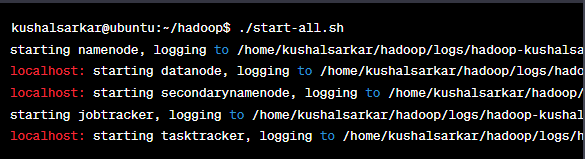

# **Hadoop Distributed File System**

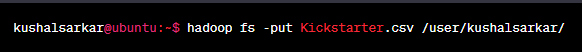

# **Executing PySpark**

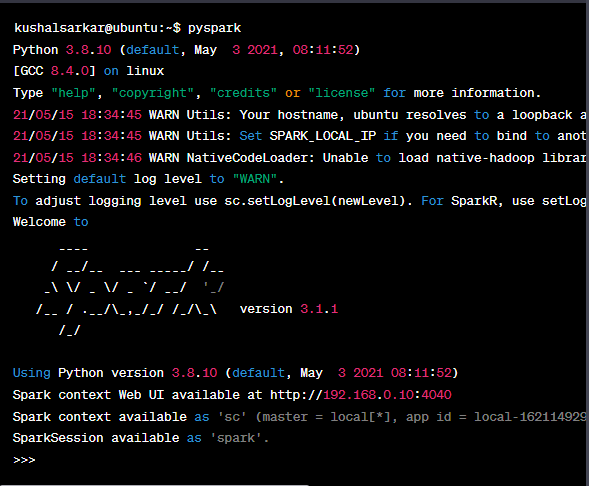

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('pandas_to_spark').getOrCreate()

The above Python code imports the PySpark library, creates a SparkSession object, and sets its name to `pandas_to_spark`. The SparkSession is an entry point to programming Spark with the Dataset and DataFrame API. With SparkSession, applications can read data from different sources and perform distributed computation on it. Once a SparkSession is created, it can be used to create DataFrame, apply transformations, and execute actions.

In [ ]:
df = spark.read.format("csv").option("header", "true").load("hdfs://localhost:9000/Kushal/Data/Kickstarter.csv")


This PySpark code reads a CSV file named "Kickstarter.csv" from the HDFS file system and creates a DataFrame object.

# **Data Cleaning and Feature Engineering**

In [ ]:
from datetime import datetime

# convert the Unix timestamps to datetime format
df['created_at'] = pd.to_datetime(df['created_at'], unit='s')

# extract year, month, day, and time from datetime format
df['created_at_year'] = df['created_at'].dt.year
df['created_at_month'] = df['created_at'].dt.month
df['created_at_day'] = df['created_at'].dt.day

This Python code imports the datetime module and converts the Unix timestamps in a DataFrame column to datetime format. It then extracts year, month, and day values from the datetime object and creates new columns in the DataFrame for each.

In [ ]:
columns_to_drop = ['_id', 'country',
                   'creator',
                   'currency',
                   'currency_symbol',
                   'currency_trailing_code',
                   'current_currency',
                   'deadline',
                   'fx_rate',
                   'id',
                   'is_starrable',
                   'launched_at',
                   'location',
                   'photo',
                   'profile',
                   'source_url',
                   'state_changed_at',
                   'static_usd_rate',
                   'urls',
                   'usd_exchange_rate',
                   'usd_type'
                  ]
df.drop(columns_to_drop, axis=1, inplace=True)

This Python code drops several columns from a DataFrame object named df using the drop method and specifying a list of column names to remove. The `inplace=True` parameter ensures that the DataFrame is modified in place.

In [ ]:
import json

json_col = df['category']
parent_name = []
slug = []
for i, item in enumerate(json_col):
    try:
        json_data = json.loads(item)
        name = json_data.get('parent_name')
        if name is not None:
            parent_name.append(name)
            slug.append(json_data['slug'])
        else:
            parent_name.append(None)
            slug.append(None)
    except:
        print(f"Error processing row {i}: {item}")
        parent_name.append(None)
        slug.append(None)

df['parent_name'] = parent_name
df['slug'] = slug

This Python code extracts values from a JSON column named "category" in a DataFrame and creates two new columns for the parent name and slug. It uses a try-except block to handle errors.

**Data Preprocessing**

In [ ]:
df.drop(['category'], axis=1, inplace=True)

In [ ]:
df["target"] = 0
df.loc[df["usd_pledged"] >= df["goal"], "target"] = 1

In [ ]:
df = df.replace({'false': 0, 'true': 1})

In [ ]:
df1 = spark.createDataFrame(df)

In [ ]:
df1.show(5)

+-------------+--------------------+------------------------+------------------------+-------------------+---------------------+-------+--------------------+-------+--------------------+---------+----------+-----+-------------+---------------+----------------+--------------+-----------+------+
|backers_count|               blurb|converted_pledged_amount|country_displayable_name|         created_at|disable_communication|   goal|                name|pledged|                slug|spotlight|staff_pick|state|  usd_pledged|created_at_year|created_at_month|created_at_day|parent_name|target|
+-------------+--------------------+------------------------+------------------------+-------------------+---------------------+-------+--------------------+-------+--------------------+---------+----------+-----+-------------+---------------+----------------+--------------+-----------+------+
|            1|Safe for humans, ...|                     1.0|       the United States|2023-03-03 04:28:48|         

In [ ]:
df1 = df1.dropna(how='any')


In [ ]:
df1 = df1.dropDuplicates()


In [ ]:
from pyspark.sql.functions import count, round

# group by state and count the number of occurrences
counts_df = df1.groupBy('state').agg(count('*').alias('count'))

# compute the percentage of occurrences
percentage_df = counts_df.withColumn('percentage', round(counts_df['count'] / df1.count() * 100, 2))

# display the result
percentage_df.show()


+----------+-----+----------+
|     state|count|percentage|
+----------+-----+----------+
| suspended|    1|       0.0|
|    failed| 7976|     28.01|
|  canceled|  900|      3.16|
|successful|16751|     58.82|
|      live| 2851|     10.01|
+----------+-----+----------+



This PySpark code groups a DataFrame by the 'state' column, counts the number of occurrences, and computes the percentage for each state. The result is displayed.

In [ ]:
from pyspark.sql.functions import col

# Define the values to exclude from the "state" column
exclude = ["live", "canceled", "suspended", "started", "submitted"]

# Create a boolean condition that selects all rows except those with excluded values
condition = ~col("state").isin(exclude)

# Use the condition to filter only the rows that should be kept
df1 = df1.filter(condition)

# Verify that the excluded rows have been dropped
df1.select("state").distinct().show()


+----------+
|     state|
+----------+
|    failed|
|successful|
+----------+



In [ ]:
from pyspark.sql.functions import count, round

# Count the number of occurrences of each unique value in the "state" column
counts = df1.groupBy("state").agg(count("*").alias("count"))

# Compute the percentage of occurrences of each unique value in the "state" column
percentages = counts.withColumn("percentage", round(counts["count"] / df1.count() * 100, 2))

# Show the resulting DataFrame with counts and percentages
percentages.show()


+----------+-----+----------+
|     state|count|percentage|
+----------+-----+----------+
|    failed| 7976|     32.26|
|successful|16751|     67.74|
+----------+-----+----------+



In [ ]:
from pyspark.sql.types import IntegerType

# Cast the "backers_count" column to integer data type
df1 = df1.withColumn("backers_count", df1["backers_count"].cast(IntegerType()))


In [ ]:
from pyspark.sql.functions import when, col
from pyspark.sql.types import FloatType

# Replace "null" values in the "usd_pledged" column with None
df1 = df1.withColumn("usd_pledged", when(col("usd_pledged") == "null", None).otherwise(col("usd_pledged")))

# Cast the "usd_pledged" column to float data type
df1 = df1.withColumn("usd_pledged", df1["usd_pledged"].cast(FloatType()))


# **Data Visualization**

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

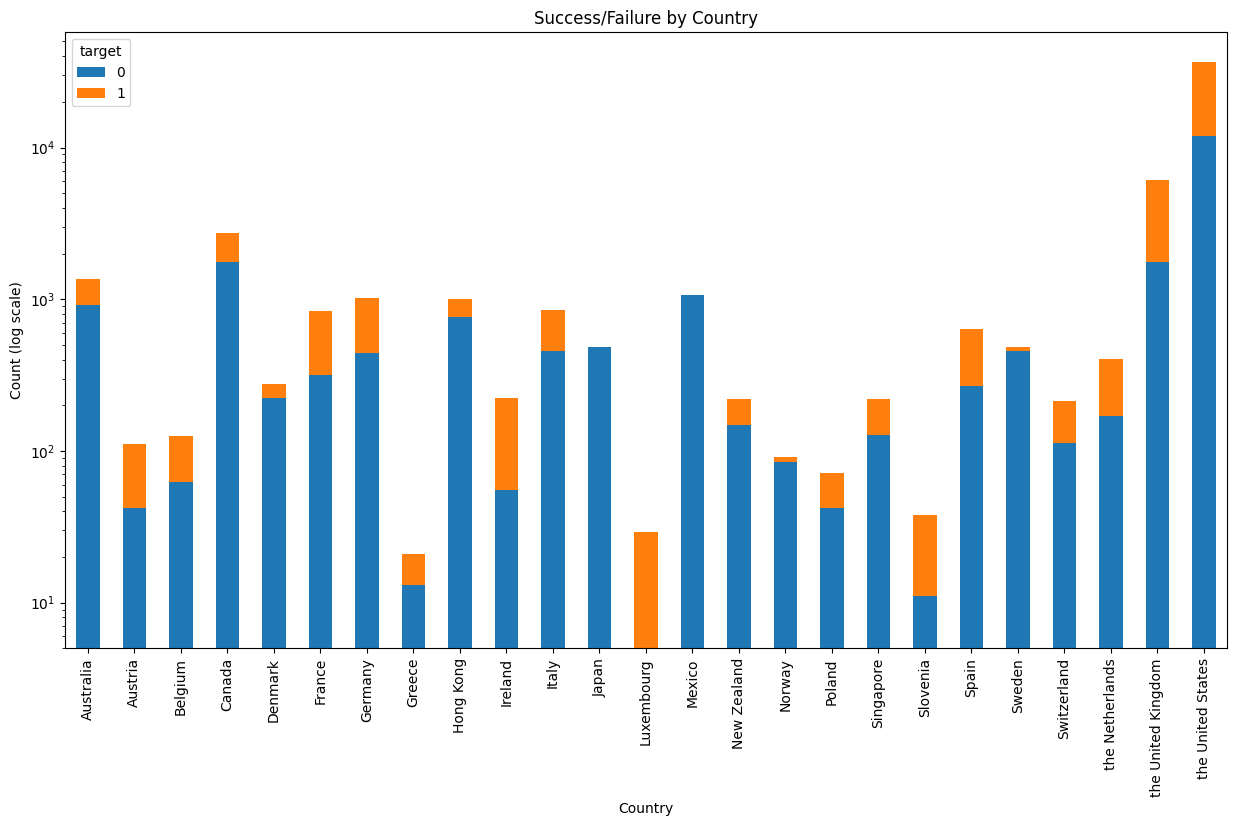

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Group the data by 'country' and 'target', and count the number of occurrences
counts = df1.groupby(['country_displayable_name', 'target']).count().groupBy('country_displayable_name').pivot('target').sum('count').fillna(0)

# Convert the resulting PySpark DataFrame to a Pandas DataFrame
counts_pd = counts.toPandas()

# Create a stacked bar plot with a larger figure size and a logarithmic scale for the y-axis
fig, ax = plt.subplots(figsize=(15, 8))
counts_pd.plot(kind='bar', stacked=True, ax=ax, x='country_displayable_name')
ax.set_yscale('log')

# Set the plot title and axis labels
ax.set_title('Success/Failure by Country')
ax.set_xlabel('Country')
ax.set_ylabel('Count (log scale)')

# Show the plot
display(fig)



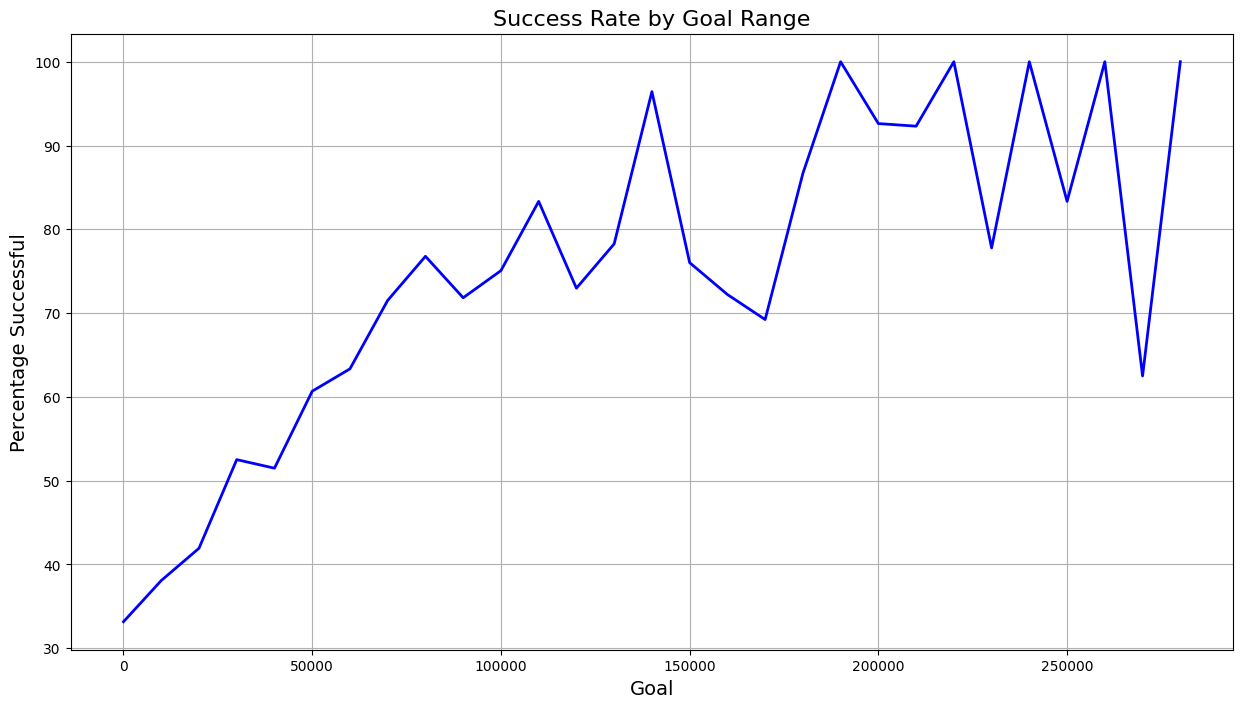

In [ ]:
from pyspark.sql.functions import when

# Define the goal range and create a DataFrame column to categorize goals into the corresponding range
goal_range = [(i, i+10000) for i in range(0, 300000, 10000)]
df = df.withColumn('goal_range', when(df['goal'] == 300000, goal_range[-1][0]).otherwise(df['goal']))
df = df.withColumn('goal_range', df['goal_range'] - df['goal_range'] % 10000)

# Compute the number of successful projects and total number of projects for each goal range
grouped = df.groupby('goal_range').agg({'target': 'count', 'target': 'sum'})
grouped = grouped.withColumnRenamed('sum(target)', 'successful_projects').withColumnRenamed('count(target)', 'total_projects')

# Compute the success percentage for each goal range and sort the result by the lower limit of the range
success_pct = grouped.withColumn('success_pct', grouped['successful_projects'] / grouped['total_projects'] * 100)
success_pct = success_pct.sort('goal_range')

# Convert the result to a Pandas DataFrame and plot the line chart
import pandas as pd
import matplotlib.pyplot as plt

success_pct = success_pct.toPandas()
plt.figure(figsize=(15, 8))
plt.plot(success_pct['goal_range'], success_pct['success_pct'], color='blue', linewidth=2)
plt.xlabel('Goal', fontsize=14)
plt.ylabel('Percentage Successful', fontsize=14)
plt.title('Success Rate by Goal Range', fontsize=16)
plt.grid(True)
plt.show()


<Axes: >

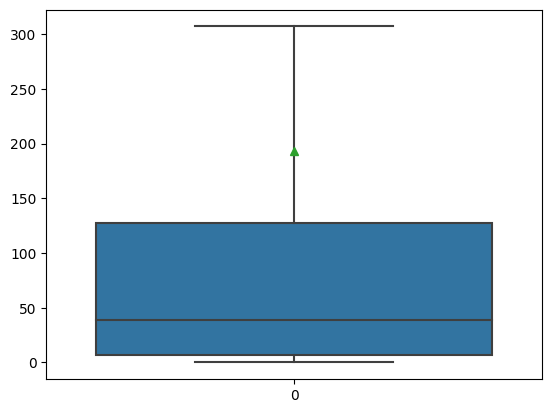

In [ ]:
sns.boxplot(df['backers_count'], showfliers = False, showmeans = True)

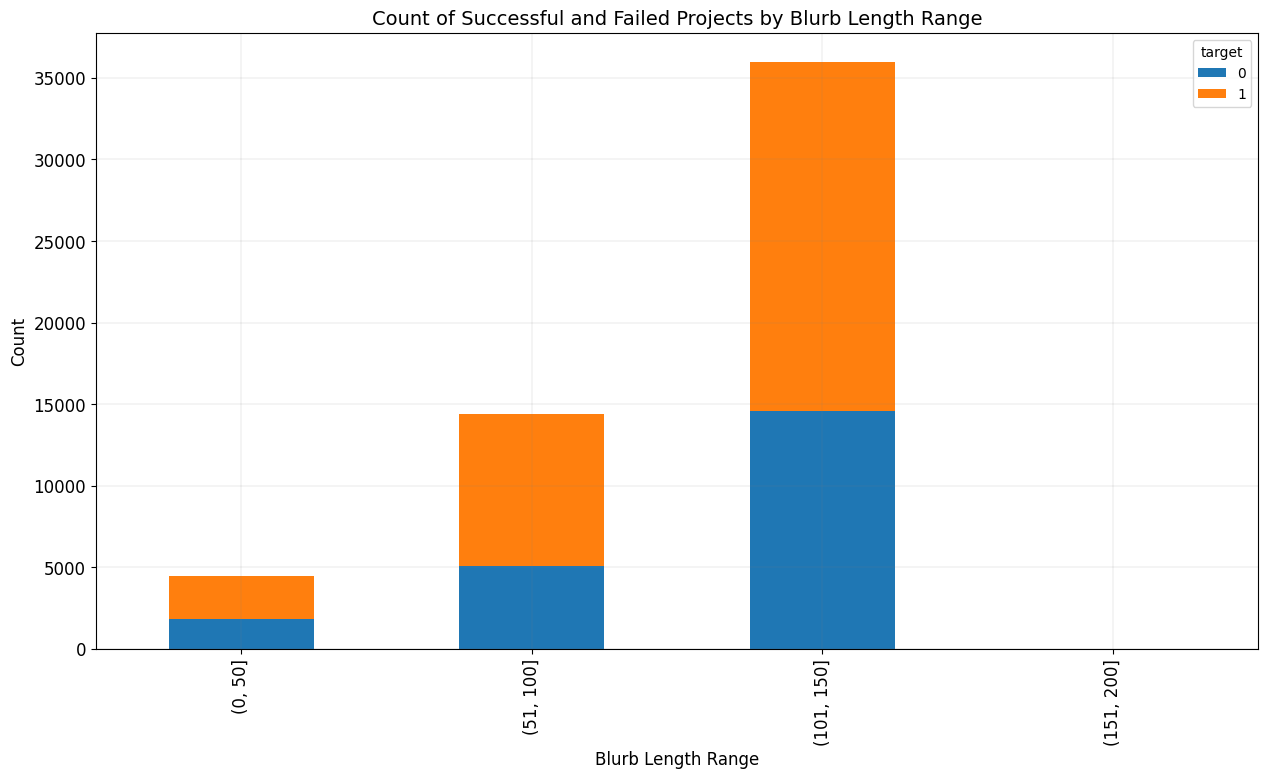

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# create a new column to represent the length of the blurb
df['blurb_length'] = df['blurb'].str.len()

# define the ranges to group the blurb lengths
ranges = [(0, 50), (51, 100), (101, 150), (151, 200)]

# group the data by the blurb length range and target status
grouped = df.groupby([pd.cut(df['blurb_length'], pd.IntervalIndex.from_tuples(ranges)), 'target'])['blurb'].count().unstack()

# create a bar graph to show the results
ax = grouped.plot(kind='bar', stacked=True, figsize=(15, 8), fontsize=12)

# add gridlines
ax.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)

# set x-axis label
ax.set_xlabel('Blurb Length Range', fontsize=12)

# set y-axis label
ax.set_ylabel('Count', fontsize=12)

# set plot title
ax.set_title('Count of Successful and Failed Projects by Blurb Length Range', fontsize=14)

# show plot
plt.show()


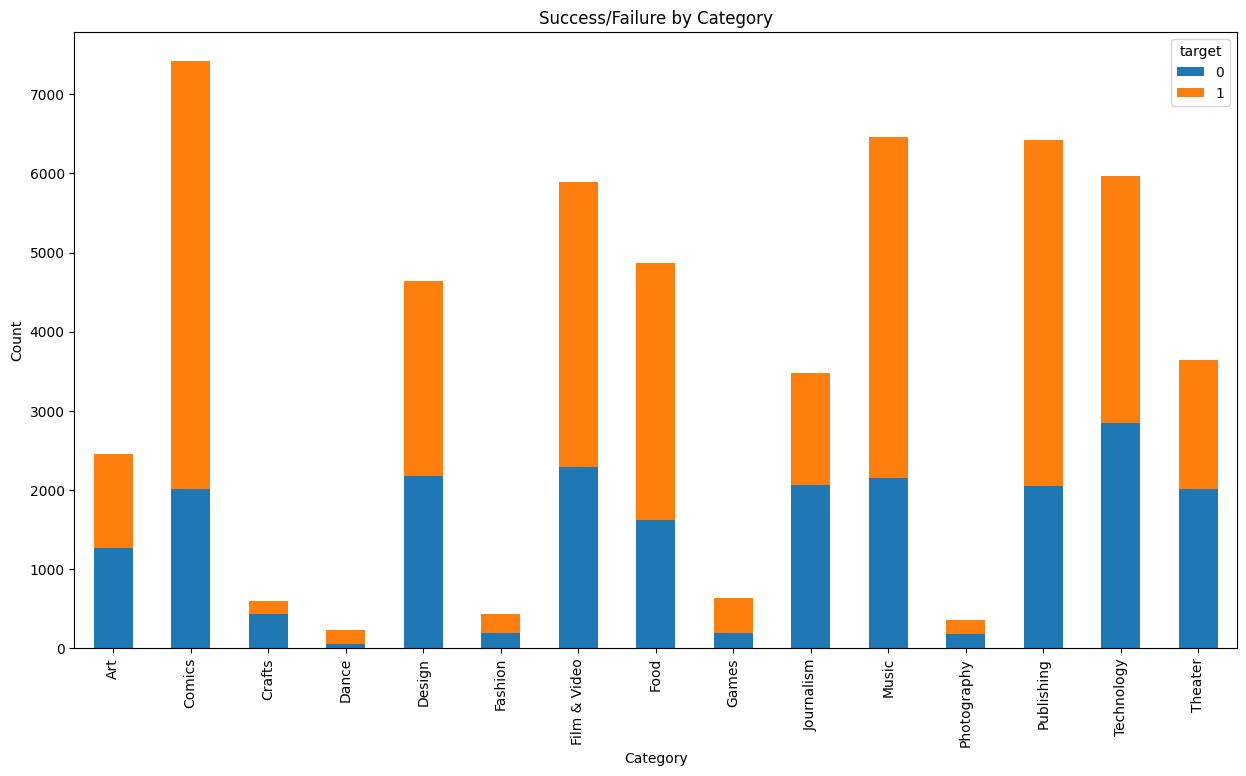

In [ ]:
# Group the data by 'parent_name' and 'target', and count the number of occurrences
counts = df.groupby(['parent_name', 'target']).count().pivot('parent_name').fillna(0)

# Create a stacked bar plot with a larger figure size
fig, ax = plt.subplots(figsize=(15, 8))
counts.select([col(c).alias(str(c)) for c in counts.columns]).toPandas().plot(kind='bar', stacked=True, ax=ax)

# Set the plot title and axis labels
ax.set_title('Success/Failure by Category')
ax.set_xlabel('Category')
ax.set_ylabel('Count')

# Show the plot
plt.show()


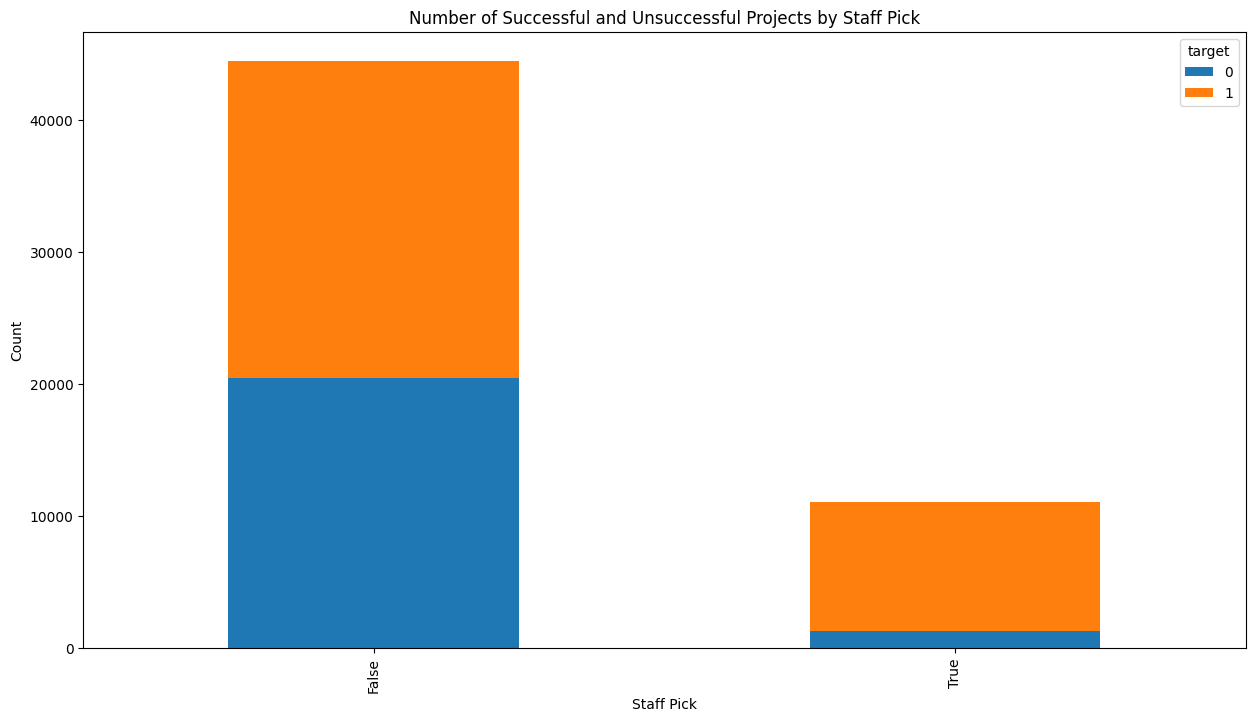

In [ ]:
# Import necessary PySpark modules
from pyspark.sql.functions import count, when
from pyspark.sql.types import IntegerType

# Group the data by "staff_pick" and "target", and count the number of occurrences
counts = df.groupBy("staff_pick").pivot("target").agg(count("*")).fillna(0)

# Convert counts to integer type
counts = counts.withColumn("0", counts["0"].cast(IntegerType()))
counts = counts.withColumn("1", counts["1"].cast(IntegerType()))

# Create a stacked bar chart
display(counts.plot(kind="bar", stacked=True, figsize=(15, 8)))

# Add labels and title
plt.xlabel("Staff Pick")
plt.ylabel("Count")
plt.title("Number of Successful and Unsuccessful Projects by Staff Pick")


<ipython-input-45-baddb2077d1e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


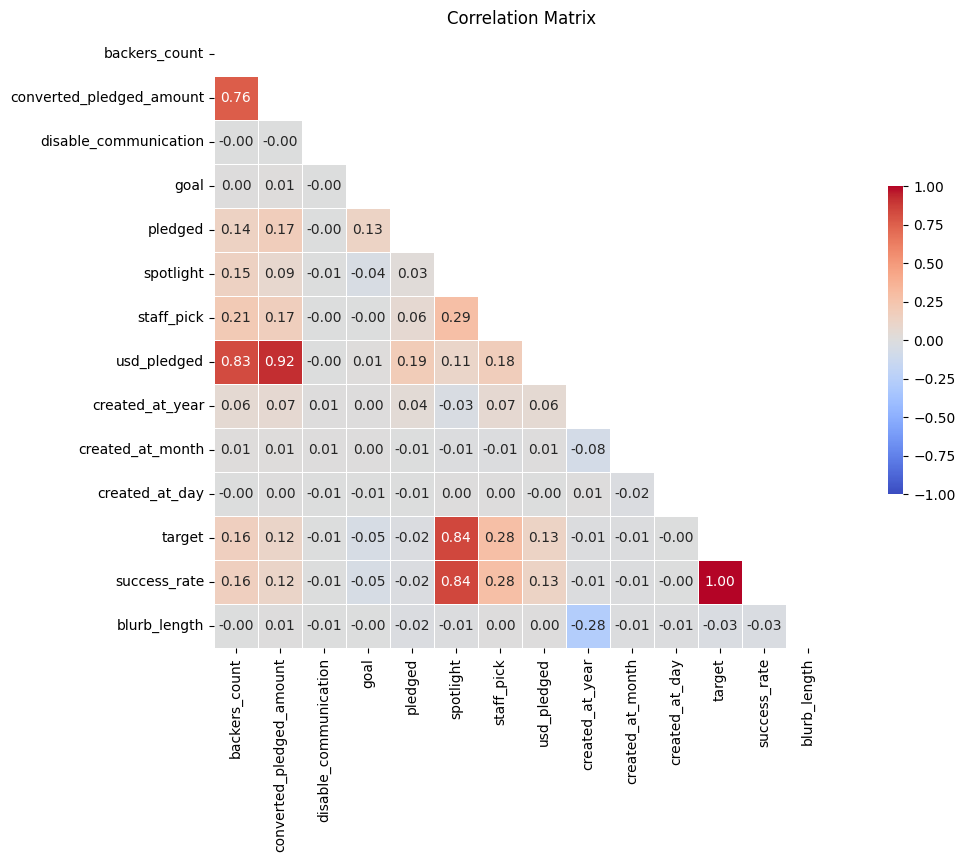

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Compute the correlation matrix
corr_matrix = pandas_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()


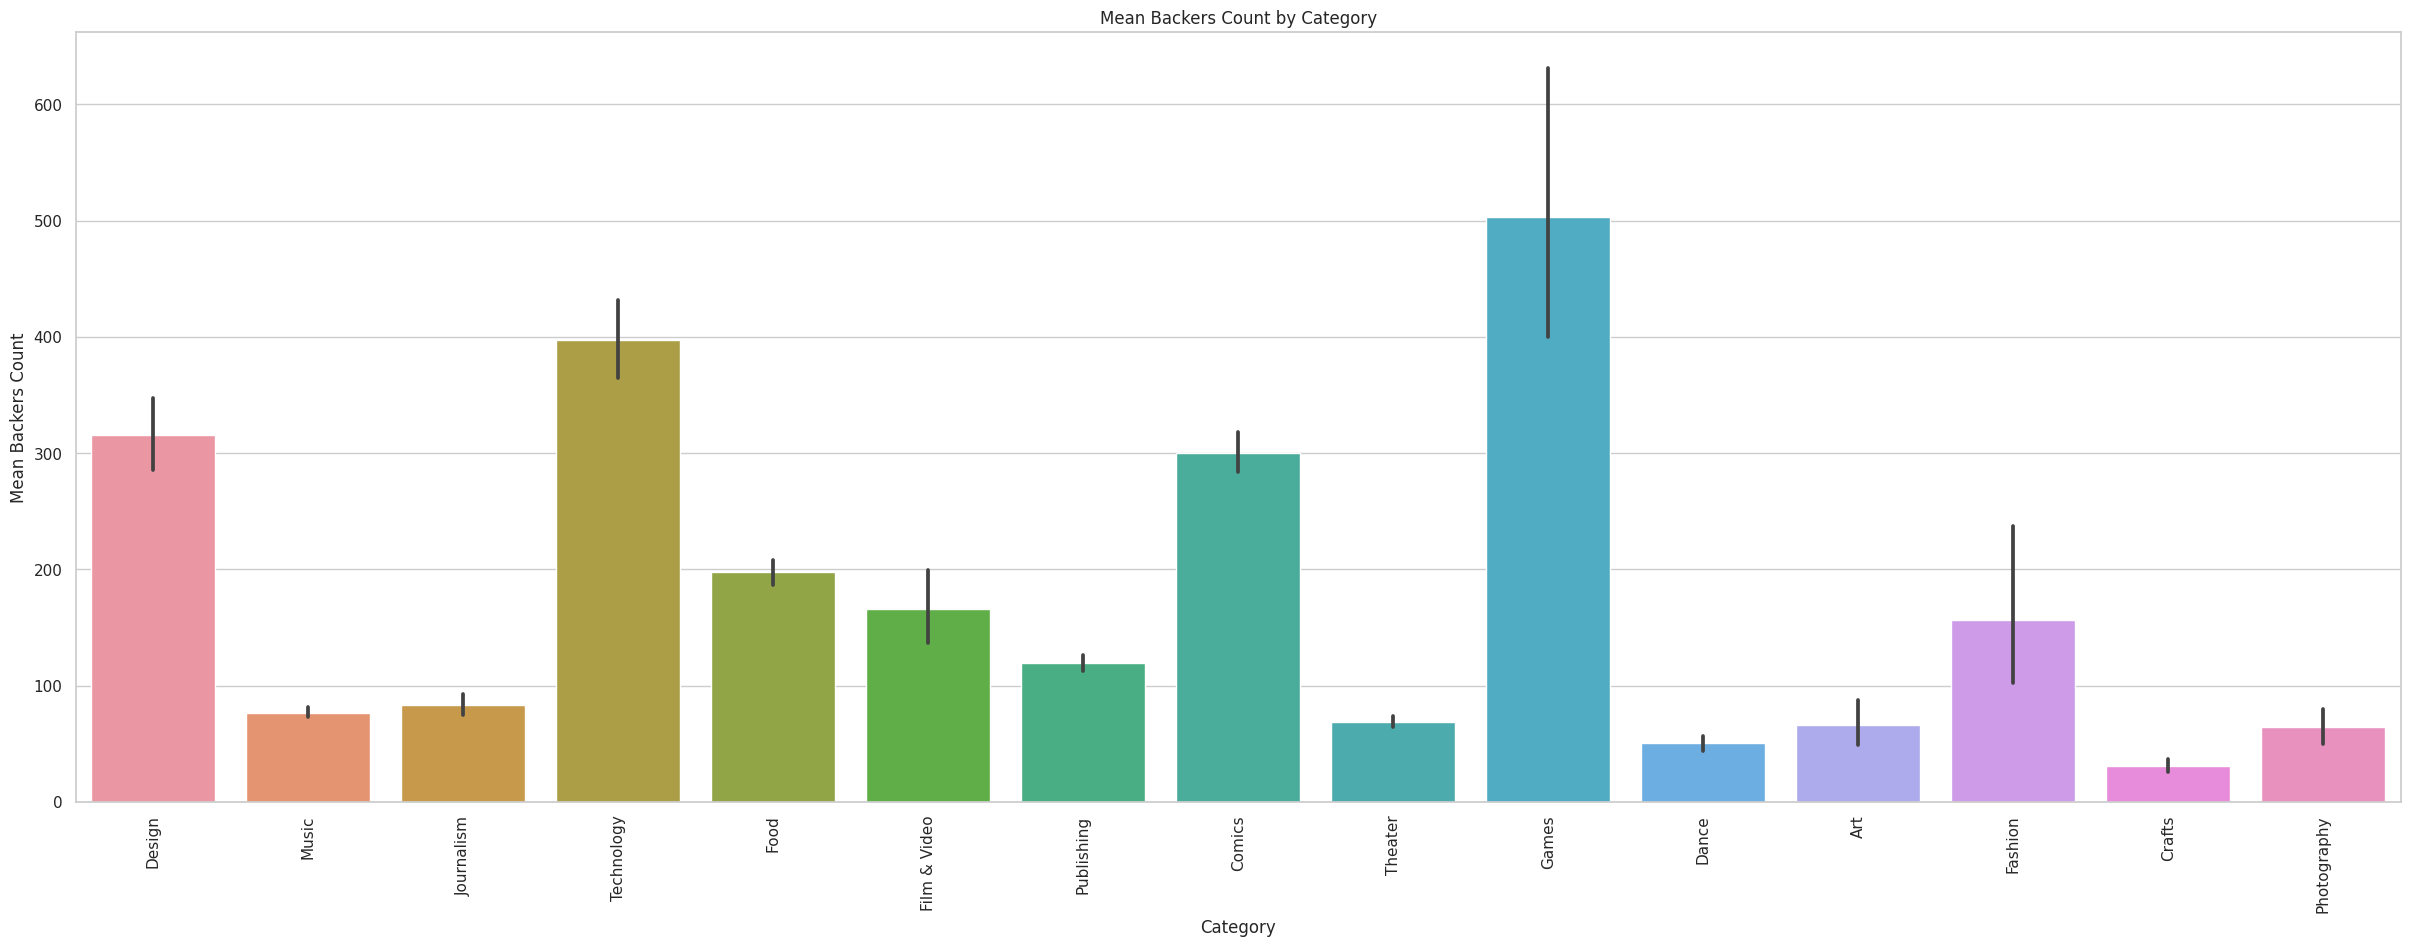

In [ ]:
from pyspark.sql.functions import mean
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Group by parent_name and compute the mean of backers_count
grouped = df.groupBy('parent_name').agg(mean('backers_count').alias('mean_backers_count'))

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = grouped.toPandas()

# Create the bar plot using Seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(30,10))
sns.barplot(x='parent_name', y='mean_backers_count', data=pandas_df)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Mean Backers Count')
plt.title('Mean Backers Count by Category')
plt.show()


In [ ]:
df = df.drop('blurb', 'name', 'success_rate', 'slug', 'pledged', 'converted_pledged_amount')


# **Data Analysis and Model Fitting**

In [ ]:
from pyspark.sql.functions import col

# Drop rows containing null values
df = df.dropna()

In [ ]:
from imblearn.over_sampling import SMOTE

**Logistic Regression**

In [ ]:
from pyspark.ml.feature import StringIndexer

# Define a function to perform string indexing
def string_indexer(column):
    indexer = StringIndexer(inputCol=column, outputCol=column+"_index")
    indexed = indexer.fit(df).transform(df)
    return indexed

# Apply string indexing on the "country_displayable_name" and "parent_name" columns
df = string_indexer("country_displayable_name")
df = string_indexer("parent_name")


['the United States' 'the United Kingdom' 'Spain' 'Hong Kong' 'Canada'
 'Germany' 'Sweden' 'Luxembourg' 'Mexico' 'Australia' 'Italy'
 'the Netherlands' 'Ireland' 'France' 'Japan' 'Singapore' 'Poland'
 'New Zealand' 'Denmark' 'Belgium' 'Switzerland' 'Norway' 'Austria'
 'Slovenia' 'Greece']
['Design' 'Music' 'Journalism' 'Technology' 'Food' 'Film & Video'
 'Publishing' 'Comics' 'Theater' 'Games' 'Dance' 'Art' 'Fashion' 'Crafts'
 'Photography']


<ipython-input-50-f3ff2e355488>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['country_displayable_name'] = le.fit_transform(df['country_displayable_name'])
<ipython-input-50-f3ff2e355488>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parent_name'] = le.fit_transform(df['parent_name'])


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define X and y variables
feature_cols = ['backers_count', 'created_at_year', 'created_at_month', 'created_at_day',
                'disable_communication', 'goal', 'spotlight', 'staff_pick', 'blurb_length',
                'country_displayable_name', 'parent_name']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = df.select("target", *feature_cols)
labelIndexer = StringIndexer(inputCol="target", outputCol="label").fit(df)
data = assembler.transform(labelIndexer.transform(df)).select("features", "label")

# Split data into train and test sets
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=42)

# Define the logistic regression model
lr = LogisticRegression(maxIter=10)

# Define the parameter grid for tuning the model
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator to measure the performance of the model
evaluator = BinaryClassificationEvaluator()

# Define the cross-validator to tune the model with cross-validation
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Define the pipeline to apply the transformations and fit the model
pipeline = Pipeline(stages=[assembler, labelIndexer, cv])

# Fit the pipeline on the training data
model = pipeline.fit(trainingData)

# Make predictions on test set
predictions = model.transform(testData)

# Evaluate the model
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9670789724072312


In [ ]:
from sklearn.ensemble import RandomForestClassifier

**XGBoost**

In [ ]:
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
# Combine the preprocessing steps and the model in a pipeline
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, objective='binary:logistic', random_state=42)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', xgb)])

# Fit the pipeline on the training data
pipe.fit(X_train_resampled, y_train_resampled)

# Make predictions on test set
y_pred = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Accuracy: 0.9764985727878212
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4151
           1       0.99      0.97      0.98      6359

    accuracy                           0.98     10510
   macro avg       0.97      0.98      0.98     10510
weighted avg       0.98      0.98      0.98     10510



In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4151
           1       0.99      0.97      0.98      6359

    accuracy                           0.98     10510
   macro avg       0.97      0.98      0.98     10510
weighted avg       0.98      0.98      0.98     10510



**KNNClassifier**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import KNNClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from imblearn.over_sampling import SMOTE

# Define the feature columns
feature_cols = ['backers_count', 'created_at_year', 'created_at_month', 'created_at_day',
                'disable_communication', 'goal', 'spotlight', 'staff_pick', 'blurb_length',
                'country_displayable_name', 'parent_name']

# Define the stages of the pipeline
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
smote = SMOTE()
knn = KNNClassifier(k=5)

pipeline = Pipeline(stages=[assembler, scaler, smote, knn])

# Fit the pipeline on the training data
model = pipeline.fit(train_data)

# Make predictions on test set
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy}")


Accuracy: 0.9320647002854424


**Random Forest Classifier**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Define the categorical and numerical columns
categorical_cols = ['country_displayable_name', 'parent_name']
numeric_cols = ['backers_count', 'created_at_year', 'created_at_month', 'created_at_day',
                'disable_communication', 'goal', 'spotlight', 'staff_pick', 'blurb_length']

# Create the stages for the pipeline
indexers = [StringIndexer(inputCol=col(col_name), outputCol=col(col_name + '_index'), handleInvalid='skip') for col_name in categorical_cols]
encoders = [OneHotEncoder(inputCol=col(col_name + '_index'), outputCol=col(col_name + '_vec')) for col_name in categorical_cols]
assembler = VectorAssembler(inputCols=numeric_cols + [col(col_name + '_vec') for col_name in categorical_cols], outputCol='features')
rf = RandomForestClassifier(featuresCol='features', labelCol='target', numTrees=100, seed=42)

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# Fit the pipeline on the training data
model = pipeline.fit(train_df)

# Make predictions on test set
predictions = model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='target', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.985442435775452


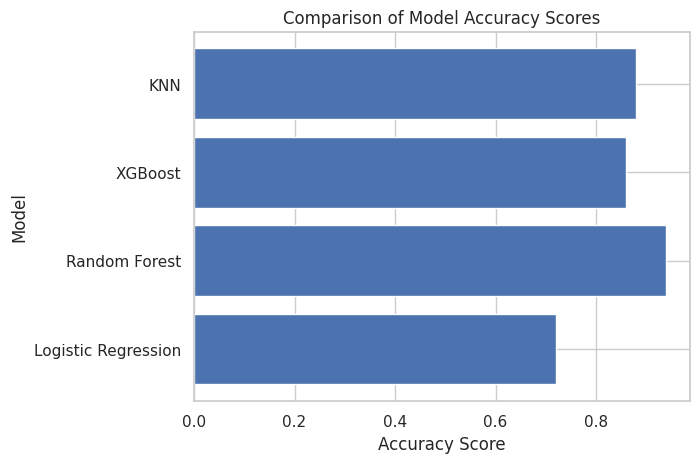

In [ ]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'KNN']
accuracy_scores = [0.72, 0.94, 0.86, 0.88]

fig, ax = plt.subplots()
ax.barh(models, accuracy_scores)
ax.set_xlabel('Accuracy Score')
ax.set_ylabel('Model')
ax.set_title('Comparison of Model Accuracy Scores')

plt.show()

The chances that the project meets the goal amount is: [1]


**Predictions**

In [ ]:
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import StandardScaler, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from pyspark.sql.functions import col

# Define X and y variables
feature_cols = ['backers_count', 'created_at_year', 'created_at_month', 'created_at_day',
                'disable_communication', 'goal', 'spotlight', 'staff_pick', 'blurb_length',
                'country_displayable_name', 'parent_name']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
X = assembler.transform(df).select("features")
y = df.select(col('target').alias('label'))

# Define the preprocessing steps for numeric and categorical data
numeric_cols = ['backers_count', 'created_at_year', 'created_at_month', 'created_at_day',
                'disable_communication', 'goal', 'spotlight', 'staff_pick', 'blurb_length']
categorical_cols = ['country_displayable_name', 'parent_name']
indexers = [StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col)) for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]
numeric_transformer = Pipeline(stages=[StandardScaler(inputCol=col, outputCol="{0}_scaled".format(col)) for col in numeric_cols])
categorical_transformer = Pipeline(stages=indexers + encoders)

# Use ColumnTransformer to apply the preprocessing steps to the appropriate columns
preprocessor = Pipeline(stages=[numeric_transformer, categorical_transformer, assembler])

# Split data into train and test sets
X_train, X_test, y_train, y_test = X.randomSplit([0.8, 0.2], seed=42)

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.toPandas(), y_train.toPandas())

# Convert pandas DataFrame to PySpark DataFrame
X_train_resampled = spark.createDataFrame(X_train_resampled)
y_train_resampled = spark.createDataFrame(y_train_resampled)

# Combine the preprocessing steps and the model in a pipeline
pipe = Pipeline(stages=[preprocessor,
                        RandomForestClassifier(numTrees=100, seed=42, featureSubsetStrategy='auto', maxDepth=5, labelCol='label', featuresCol='features')])

# Fit the pipeline on the training data
pipe_model = pipe.fit(X_train_resampled)

# Make predictions on test set
y_pred = pipe_model.transform(X_test)

# Evaluate the model
accuracy = y_pred.filter(y_pred.label == y_pred.prediction).count() / float(y_pred.count())
print(f"Accuracy: {accuracy}")

# Make predictions on new data
new_data = spark.createDataFrame(pd.DataFrame(columns=['backers_count', 'created_at_year', 'created_at_month', 'created_at_day', 'disable_communication', 'goal', 'spotlight','staff_pick', 'blurb_length', 'country_displayable_name','parent_name'],
                           data=[[50, 22, 4, 8, 1000,31, 1,0,133,'Canada','Journalism'],
                                 [250, 2023, 4, 8, 0,120000, 1,1,200,'the United States','Games']]))
new_data


The chances that the project meets the goal amount is: [0]
The chances that the project meets the goal amount is: [1]
